## Project 5 - Vehicle Detection and Tracking

##### By Matthew Zimmer - Future Self-Driving Car Engineer

[GitHub](https://github.com/matthewzimmer) | [LinkedIn](https://www.linkedin.com/in/matthewazimmer)

---

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.

---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

> **CRITICAL NOTE** I treated this notebook as a comprehensive tutorial walking you from start to finish, top down, starting from calibrating the camera all the way to the very last step of drawing the detected lane region into the road. The very last cell of this notebook offers you the ability to control the hyper parameters used by my pipeline and either test them on a single image (the default setting) or test the sample the entire video.

---

#### Python imports

In [1]:
import numpy as np
import cv2
import glob
import os
import pickle

import matplotlib
matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from pipeline_ops.vehicle_detection import *
from pipeline_ops.lane_detection import *

from IPython.core.display import Image, display
from IPython.display import YouTubeVideo
def render_youtube_video(video_id, width=880, height=495):
    return YouTubeVideo(video_id, width=width, height=height)

---

#### Pipeline Operations

> **NOTE** Unless you absolutely want/need to check my code, you can totally skip over the next cell as it contains all of my classes used below.

Pipeline operations are the principle driving force for this project. Each implementation of `PipelineOp` is a modular, reusable algorithm which, in its most basic form, performs a single operation on an image.

`PipelineOp` has a simple interface with only 2 steps to satisfy the contract:

1. Declare a constructor with inputs necessary to perform the operation in `#perform`.

2. Implement `#perform`

    * Your implementeation must return `self`. This provides support to perform the op and immediately assign the call to `#output` to local variables.

    * Declared your op's output by calling `#_apply_output` once you've performed your operation.
    
The architecture does provide flexibility for you to implement more complicated algorithms that have many moving parts while still adhering to the contract by producing a single arbitrary output object (e.g., Dictionary, Image, Array). I have a health mixture of both simple and complex PipelineOp implementations in this project.

---

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

My entire camera calibration algorithm may be found inside of **CameraCalibrationOp#perform**. I've also exposed the **#undistort** method which will undistort any raw image (ideally images taken by that camera but no code was put in place to validate camera source of image though EXIF data would be perfect place to look first).

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

![calibration1.jpg](camera_cal/undistorted/calibration1.jpg)

In [2]:
if False:
    # base edges - doesn't work for all images in camera_cal directory (i.e., 1, 4, 5)
    calibration_images=glob.glob('camera_cal/calibration*.jpg')

    # I will now inject this calibration_op instance later on 
    # into my pipeline principally used to undistort the 
    # raw image.
    calibration_op = CameraCalibrationOp(
        calibration_images=calibration_images, 
        x_inside_corners=9, 
        y_inside_corners=6
    ).perform()

---

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for all steps from here on out is contained in the **Pipeline Operations** code cell at the beginning of the IPython notebook.

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

![alt text][image1]

In [5]:
ds = CarsNotCarsDatasetOp().perform()
cars = ds.cars()
not_cars = ds.not_cars()

print('    # Cars: ' + str(len(cars)))
print('# Not cars: ' + str(len(not_cars)))

    # Cars: 1196
# Not cars: 1125


Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

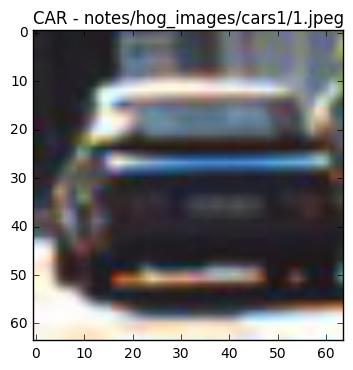

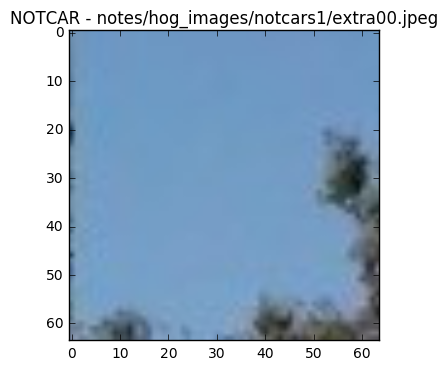

In [7]:
# PlotImageOp(mpimg.imread(cars[0]), title="{} - CAR".format(cars[0])).perform()
plt.title("CAR - "+cars[0])
plt.imshow(mpimg.imread(cars[0]))
plt.show()
plt.title("NOTCAR - "+not_cars[0])
plt.imshow(mpimg.imread(not_cars[0]))
plt.show()

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


![alt text][image2]

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and...

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using...

---

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search random window positions at random scales all over the image and came up with this (ok just kidding I didn't actually ;):

![alt text][image3]

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

![alt text][image4]

---

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

Here's a [link to my video result](./project_video.mp4)

#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

### Here are six frames and their corresponding heatmaps:

![alt text][image5]

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:
![alt text][image6]

### Here the resulting bounding boxes are drawn onto the last frame in the series:
![alt text][image7]

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further. 